To count tokens: Use the following

```
from token_count import TokenCount
tc = TokenCount(model_name="gpt-4-turbo")
tokens = {"input": 0, "output": 0}
```

In [1]:
from datasets import load_dataset, Dataset
import sys, os, json, re
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
from tqdm.auto import tqdm, trange
from rouge import Rouge
import dotenv, os

dotenv.load_dotenv()

from openai import OpenAI
client = OpenAI(api_key=os.getenv("GPT4_PISTERLABS"))


def rouge_scorer():
    # Initialize the Rouge object
    rouge = Rouge()

    def compute_scores(generated_text, reference_text):
        # Compute the scores
        scores = rouge.get_scores(generated_text, reference_text)[0]
        total_score = 0
        for r in scores:
            total_score += scores[r]['f']
        return total_score/3

    return compute_scores

def check_and_reformat(prompt):
    """
    Checks if prompt is valid. If prompt is valid, returns a slightly modified prompt that can be evaluated and optimized.
    """
    pattern1 = r'{[^}]*}'
    pattern2 = r'PLACEHOLDER'
    matches1 = re.findall(pattern1, prompt)
    matches2 = re.findall(pattern2, prompt.upper())
    print(matches1, matches2)

    assert len(matches1) == 1 or len(matches2) == 1, "Invalid prompt format. Prompt must contain some str/var to be interpolated."

    # Reformat the prompt
    if len(matches1) == 1:
        return prompt.replace(matches1[0], "{TEXT}")
    else:
        return prompt.replace(matches2[0], "{TEXT}")

# Usage
score_rouge = rouge_scorer()
CHOSEN_PROMPT = 'Please summarize the following text: PLACEHOLDER'  # somewhere in promptset. Will find idx later
CHOSEN_PROMPT = check_and_reformat(CHOSEN_PROMPT)
CHOSEN_PROMPT

[] ['PLACEHOLDER']


'Please summarize the following text: {TEXT}'

### Generate Synthetic Data

In [2]:
# Generate a question and answer pair using a language model
def generate_synthetic_data(sample_size = 40):
    # Check if the synthetic data already exists
    SYNTHETIC_DATA_FILEPATH = "synthetic_summarization_dataset.json"
    if os.path.exists(SYNTHETIC_DATA_FILEPATH):
        # Reading saved data
        with open(SYNTHETIC_DATA_FILEPATH, "r") as f:
            text_summary_pairs = eval(f.read())
        return text_summary_pairs

    def generate_synthetic_datapoint():
        prompt_template = """You are a helpful assistant designed to generate synthetic text-summary pairs for the prompt: {CHOSEN_PROMPT}.

    Please generate synthetic data for the summarization prompt. Response with a JSON object with "text" and "summary" keys. The values must both be string values.

    Take a deep breath and think step-by-step. Respond with only the JSON object!
    """
        response = client.chat.completions.create(
            model="gpt-4-turbo",
            messages=[
                {"role": "user", "content": prompt_template.format(CHOSEN_PROMPT=CHOSEN_PROMPT)},
            ],
            temperature=1.0,
            response_format={"type": "json_object"}
            ).choices[0].message.content
        print(response)
        return eval(response)

    text_summary_pairs = []

    # Generating synthetic data
    pbar = tqdm(total=sample_size)
    while len(text_summary_pairs) < sample_size:
        try:
            data_pair = generate_synthetic_datapoint()
            text_summary_pairs.append(data_pair)
            pbar.update(1)
        except Exception as e:
            print(e)
    pbar.close()

    # Saving to file
    with open(SYNTHETIC_DATA_FILEPATH, "w") as f:
        f.write(str(text_summary_pairs))

    return text_summary_pairs

synthetic_data = generate_synthetic_data()
synthetic_data[:5]

  0%|          | 0/40 [00:00<?, ?it/s]

{
    "text": "Despite recent advances in renewable energy, global warming continues to pose a serious threat to our planet’s ecosystems and human populations alike. According to data from several environmental research groups, the average global temperature has risen by 1.1 degrees Celsius since the pre-industrial era. This increase in temperature is directly linked to the rise in greenhouse gases emitted by human activities, primarily from the burning of fossil fuels. Scientists warn that if significant reductions in CO2 emissions are not made soon, the consequences could include severe weather changes, loss of biodiversity, and detrimental health impacts for people worldwide.",
    "summary": "Global warming remains a critical issue, as the average global temperature has increased by 1.1 degrees Celsius since the pre-industrial era, primarily due to greenhouse gas emissions from burning fossil fuels. Urgent action is required to reduce CO2 emissions to mitigate severe climatic chang

[{'text': 'Despite recent advances in renewable energy, global warming continues to pose a serious threat to our planet’s ecosystems and human populations alike. According to data from several environmental research groups, the average global temperature has risen by 1.1 degrees Celsius since the pre-industrial era. This increase in temperature is directly linked to the rise in greenhouse gases emitted by human activities, primarily from the burning of fossil fuels. Scientists warn that if significant reductions in CO2 emissions are not made soon, the consequences could include severe weather changes, loss of biodiversity, and detrimental health impacts for people worldwide.',
  'summary': 'Global warming remains a critical issue, as the average global temperature has increased by 1.1 degrees Celsius since the pre-industrial era, primarily due to greenhouse gas emissions from burning fossil fuels. Urgent action is required to reduce CO2 emissions to mitigate severe climatic changes, bi

In [3]:
TRAINING_SAMPLE_SIZE = 10
TESTING_SAMPLE_SIZE = 30

training_sample = synthetic_data[:TRAINING_SAMPLE_SIZE]

testing_sample = synthetic_data[TRAINING_SAMPLE_SIZE:TRAINING_SAMPLE_SIZE+TESTING_SAMPLE_SIZE]

# Checking if the lists are parallel, i.e. the question and answer at the same index are related
len(training_sample), len(testing_sample)

(10, 30)

### Optimize Prompt on Synthetic Data

In [4]:
# Scoring the instruction using the sample
def opt_llm(prompt_score_pairs):
    has_correct_keywords = lambda prompt: re.findall(r'{(.*?)}', prompt) == ['TEXT']
    # Format the instruction and score pairs into a string
    pairs_str = ""
    for ins, score in prompt_score_pairs.items():
        pairs_str += f"text:\n{ins}\nscore:\n{score:.2f}\n\n"

    # prompt = """Below is the set of optimization...

    # Following is the better prompt..

    # TODO: Remove 1st/2nd person narrative.

    
    # """

    prompt = """You are an optimization expert. The user has some texts along with their corresponding scores.
Your task is to generate a new piece of text that scores as high as possible. 
Generate the new unique text only, not its corresponding score.

Here are some texts along with their corresponding scores. The texts are arranged in ascending order
based on their scores, where higher scores indicate better quality.

{pairs_str}

Write your new text that is different from the old ones and has a score as high as possible.
Generate the new unique text only, not its corresponding score.
New instruction:
"""
    response = ""
    while not has_correct_keywords(response):
        response = response = client.chat.completions.create(
            model="gpt-4-turbo",
            messages=[
                {"role": "user", "content": prompt.format(pairs_str=pairs_str)},
            ],
            temperature=1.0,
            ).choices[0].message.content
    return response


def score(prompt, sample):
    """
    Score the instruction using the sample.

    Args:
    instruction: str
    sample: Dataset with "question" and "answer" as keys

    Returns:
    accuracy: float
    """
    accuracy = 0
    with tqdm(sample, desc=prompt, position=1, leave=False) as pbar:
        for idx, data_pair in enumerate(pbar):
            res = client.chat.completions.create(
                model="gpt-4-turbo",
                messages=[
                    {"role": "user", "content": prompt.format(TEXT=data_pair["text"])},
                ],
                temperature=0.0,
                ).choices[0].message.content
            # Heuristic for detecting correctness
            accuracy += score_rouge(res, data_pair["summary"])
            pbar.set_postfix({"Accuracy": f"{accuracy / (idx + 1):.2f}"})

    return accuracy / len(sample) * 100

In [5]:
SEED_PROMPTS = [
CHOSEN_PROMPT,
f"{CHOSEN_PROMPT}. Think step by step.",
f"{CHOSEN_PROMPT}. Take a deep breath.",
f"{CHOSEN_PROMPT}. Be concise and clear.",
f"{CHOSEN_PROMPT}. You are a summarization expert.",
f"{CHOSEN_PROMPT}. Explain your answer in simple terms.",
f"{CHOSEN_PROMPT}. You are a helpful assistant.",
# Prompt1 from Suggest Prompt
"""#### Instruction ####

Summarize the following text:

#### Input ####

{TEXT}

#### Expected Response Format ####

[Your summary]""",
# Prompt2 from Suggest Prompt
"""**Instruction**: Summarize the following text:

**{TEXT}**

**Example:**

* Summarize the following text:
> The United States is a large country with a diverse population. It is made up of 50 states, each with its own unique culture and history. The United States is a global superpower and has a significant influence on world affairs.

### Answer: ###
* The United States is a large, diverse country with 50 states, each with its own unique culture and history. As a global superpower, the United States exerts significant influence on world affairs.

**Additional Instructions:**

* Please ensure that your summary captures the key points of the text.
* Use clear and concise language.
* You MUST adhere to the specified word limit.
* You will be penalized if your summary is not responsive to the text.""",
# Prompt3 from Suggest Prompt
"""###Instruction###

Summarize the following text:

###Input###
{TEXT}

###Your task is###

Generate a concise and accurate summary of the input text.

###You MUST###

* Write in clear and concise language.
* Cover all the main points of the text.
* Keep the summary within 500 words.

###You will be penalized if###

* Your summary is incomplete or inaccurate.
* Your summary exceeds the 500-word limit.

###Answer in a natural, human-like manner###

Pretend you are a highly skilled human summarizing the text.

###Example###
* **QUESTION:** Summarize the following text:
{{EXAMPLE TEXT}}
* **SUMMARY:** {{EXAMPLE SUMMARY}}

###TIP###
I'm going to tip $5 for a better summary!""",
# Prompt4 from Suggest Prompt
"""###Instruction###
Your task is to summarize the following text:


###Example###
{TEXT}


You MUST answer in a natural, human-like manner. You will be penalized for not following these instructions.
###Question###
{TEXT}""",
# Prompt5 from Suggest Prompt
"""###Instruction###
Provide a concise summary of the following text:
{TEXT}
###Example###
Input: Here is the provided request: \"Summarize this research paper: Effects of Climate Change on Marine Ecosystems\"
Output: Marine ecosystems face significant threats from climate change, including rising sea temperatures, ocean acidification, and altered weather patterns. These changes disrupt ecological balances, leading to loss of biodiversity, shifts in species distribution, and reduced productivity.
###Question###
Your task is to generate a concise and informative summary of the provided text. Ensure your response is clear, concise, and free from errors. You MUST adhere to the formatting guidelines and provide a single cohesive summary. If you fail to meet these requirements, you will be penalized.
Answer in a natural, human-like manner and ensure your response is comprehensive and covers the main points of the provided text.""",
]

SEED_PROMPTS

['Please summarize the following text: {TEXT}',
 'Please summarize the following text: {TEXT}. Think step by step.',
 'Please summarize the following text: {TEXT}. Take a deep breath.',
 'Please summarize the following text: {TEXT}. Be concise and clear.',
 'Please summarize the following text: {TEXT}. You are a summarization expert.',
 'Please summarize the following text: {TEXT}. Explain your answer in simple terms.',
 'Please summarize the following text: {TEXT}. You are a helpful assistant.',
 '#### Instruction ####\n\nSummarize the following text:\n\n#### Input ####\n\n{TEXT}\n\n#### Expected Response Format ####\n\n[Your summary]',
 '**Instruction**: Summarize the following text:\n\n**{TEXT}**\n\n**Example:**\n\n* Summarize the following text:\n> The United States is a large country with a diverse population. It is made up of 50 states, each with its own unique culture and history. The United States is a global superpower and has a significant influence on world affairs.\n\n### A

In [6]:
INS_PER_STEP = 8
MAX_INS_SCORE_PAIRS = 20
SAVE_PATH = "synthetic_summarization_OPRO_results.json"
STEP_COUNT = 10

# loading saved data
if os.path.exists(SAVE_PATH):
    with open(SAVE_PATH, "r") as f:
        results = json.load(f)
    ins_score_pairs = results[str(len(results))]
else:
    ins_score_pairs = {
        ins: score(ins, training_sample)
        for ins in tqdm(SEED_PROMPTS, desc="Scoring", position=0)
    }
    results = {1: ins_score_pairs}
    with open(SAVE_PATH, "w") as f:
        json.dump(results, f)

# Each step takes aboy 5 to 10 minutes with gemma:2b
for i in range(1, STEP_COUNT + 1):
    print(f"Step {i}")
    while True:
        try:
            # Optimizer LLM
            instructions = [
                opt_llm(ins_score_pairs)
                for _ in trange(INS_PER_STEP, desc="Optimizing")
            ]
            print(instructions)

            # Scoring the new instructions
            new_ins_score_pairs = {
                ins: score(ins, training_sample)
                for ins in tqdm(instructions, desc="Scoring", position=0)
            }
            print(new_ins_score_pairs)
            combined_ins_score_pairs = {**ins_score_pairs, **new_ins_score_pairs}
            ins_score_pairs = dict(
                sorted(
                    combined_ins_score_pairs.items(), key=lambda x: x[1], reverse=True
                )[:MAX_INS_SCORE_PAIRS]
            )

            # Saving data
            results[i] = ins_score_pairs
            with open(SAVE_PATH, "w") as f:
                json.dump(results, f)

            break
        except ValueError as e:
            print(e)
        except Exception as e:
            print(e)

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Please summarize the following text: {TEXT}:   0%|          | 0/10 [00:00<?, ?it/s]

Please summarize the following text: {TEXT}. Think step by step.:   0%|          | 0/10 [00:00<?, ?it/s]

Please summarize the following text: {TEXT}. Take a deep breath.:   0%|          | 0/10 [00:00<?, ?it/s]

Please summarize the following text: {TEXT}. Be concise and clear.:   0%|          | 0/10 [00:00<?, ?it/s]

Please summarize the following text: {TEXT}. You are a summarization expert.:   0%|          | 0/10 [00:00<?, …

Please summarize the following text: {TEXT}. Explain your answer in simple terms.:   0%|          | 0/10 [00:0…

Please summarize the following text: {TEXT}. You are a helpful assistant.:   0%|          | 0/10 [00:00<?, ?it…

#### Instruction ####

Summarize the following text:

#### Input ####

{TEXT}

#### Expected Response Format #…

**Instruction**: Summarize the following text:

**{TEXT}**

**Example:**

* Summarize the following text:
> Th…

###Instruction###

Summarize the following text:

###Input###
{TEXT}

###Your task is###

Generate a concise a…

###Instruction###
Your task is to summarize the following text:


###Example###
{TEXT}


You MUST answer in a …

###Instruction###
Provide a concise summary of the following text:
{TEXT}
###Example###
Input: Here is the pro…

Step 1


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['### Guideline ###\n\n#### Task ####\n\nEfficiently summarize the following content:\n\n#### Content Details ####\n\n{TEXT}\n\n#### Instructions for Summary ####\n\n**Your objective** is to deliver a summary that is both succinct and representative of the main ideas in the text.\n\n**Requirements:**\n\n- Utilize clear and precise language to express the key concepts.\n- Ensure the summary does not exceed 300 words.\n- Highlight significant points without altering the original intent of the text.\n\n#### Desired Outcome ####\n\nA comprehensive yet brief encapsulation that provides a clear understanding of the text\'s core themes and conclusions.\n\n#### Example ####\n\n**TEXT:** "The global economy is increasingly interconnected, with vast networks facilitating trade and communication across countries. These networks, while beneficial, also pose systemic risks as problems in one area can quickly spread to others."\n\n**SUMMARY:** "The global economy is characterized by its interconnect

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

### Guideline ###

#### Task ####

Efficiently summarize the following content:

#### Content Details ####

{T…

### Summary Task Guidelines ###

#### Objective ####

Provide an eloquent and succinct summary of the text bel…

**Guidelines for Summary**

### Task Overview ###

Condense the provided text:

#### Content Provided ####
{TE…

**Guidance for Summarization**

#### Objective ####

Summarize the provided text efficiently and accurately.

…

#### Instruction ####

Summarize the given content:

#### Text to Summarize ####

{TEXT}

#### Summary Guideli…

###Instructions###

**Task**: Summarize the content provided below:

###Text###
{TEXT}

**Requirements**:

- D…

#### Summarization Task ####

**Objective:**

Concisely summarize the content provided below:

**Content Sourc…

**Guidelines for Summarization:**

**Objective:** Efficiently condense the information presented in the text b…

{'### Guideline ###\n\n#### Task ####\n\nEfficiently summarize the following content:\n\n#### Content Details ####\n\n{TEXT}\n\n#### Instructions for Summary ####\n\n**Your objective** is to deliver a summary that is both succinct and representative of the main ideas in the text.\n\n**Requirements:**\n\n- Utilize clear and precise language to express the key concepts.\n- Ensure the summary does not exceed 300 words.\n- Highlight significant points without altering the original intent of the text.\n\n#### Desired Outcome ####\n\nA comprehensive yet brief encapsulation that provides a clear understanding of the text\'s core themes and conclusions.\n\n#### Example ####\n\n**TEXT:** "The global economy is increasingly interconnected, with vast networks facilitating trade and communication across countries. These networks, while beneficial, also pose systemic risks as problems in one area can quickly spread to others."\n\n**SUMMARY:** "The global economy is characterized by its interconnect

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['### Instruction ###\n\n**Summarize the Key Points of This Text:**\n\n#### Overview ####\n{TEXT}\n\n#### Summary Requirements ####\n\n- Craft a comprehensive yet succinct encapsulation of the text\'s primary concepts.\n- Employ clear and direct language to emphasize the essential information.\n- Adhere tightly to the word limit provided, ensuring conciseness and precision.\n\n#### Expected Deliverable ####\n\n[Your concise summary]\n\n#### Points to Consider ####\n\n* Your summary must fully convey the critical elements and themes of the text.\n* Maintain linguistic clarity and brevity throughout your summary.\n* It is imperative that you do not deviate from the factual content of the original text.\n* Focus on delivering a summary that encapsulates the text informatively yet succinctly to assist understanding for any reader not familiar with the topic.\n\n### Example ###\n* **Text Provided:** "Technological advancements in biomimicry are influencing sustainable design, leading to the

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

### Instruction ###

**Summarize the Key Points of This Text:**

#### Overview ####
{TEXT}

#### Summary Requi…

#### Instruction ####

Craft a concise summary of the following text:

#### Input ####

{TEXT}

#### Key Point…

#### Instructions for Summary Creation ####

**Objective:** Efficiently condense the primary information from …

### Briefing Instructions ###

**Objective:** Summarize the enclosed material promptly and accurately.

#### C…

#### Instruction ####

Summarize the following text:

#### Text Provided ####

{TEXT}

#### Directions for Sum…

#### Summary Task Instructions ####

**Objective:**
Efficiently distill the essence of the provided text into …

#### Instruction ####

Provide a detailed summary of the following content:

#### Content to Summarize ####

{…

#### Instruction ####

Craft a Summary for the Provided Text:

#### Text ####

{TEXT}

#### Summary Requiremen…

{'### Instruction ###\n\n**Summarize the Key Points of This Text:**\n\n#### Overview ####\n{TEXT}\n\n#### Summary Requirements ####\n\n- Craft a comprehensive yet succinct encapsulation of the text\'s primary concepts.\n- Employ clear and direct language to emphasize the essential information.\n- Adhere tightly to the word limit provided, ensuring conciseness and precision.\n\n#### Expected Deliverable ####\n\n[Your concise summary]\n\n#### Points to Consider ####\n\n* Your summary must fully convey the critical elements and themes of the text.\n* Maintain linguistic clarity and brevity throughout your summary.\n* It is imperative that you do not deviate from the factual content of the original text.\n* Focus on delivering a summary that encapsulates the text informatively yet succinctly to assist understanding for any reader not familiar with the topic.\n\n### Example ###\n* **Text Provided:** "Technological advancements in biomimicry are influencing sustainable design, leading to the

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['#### Comprehensive Summary Guidelines ####\n\n**Objective:** Efficiently extract and articulate the main points from the given text.\n\n**Text for Summary:**\n{TEXT}\n\n**Summary Expectations:**\n\n- Provide a concise, clear, and factual recapitulation of the key details from the text.\n- Emphasize the primary themes, ensuring clarity and precision of language.\n- Stay tightly focused on the prescribed word limit, balancing thoroughness with brevity.\n\n**Essential Elements to Include:**\n\n- Your summary must reflect the core concepts and insights from the text without distorting its original intent.\n- Critical data or statistics presented in the text should be accurately encapsulated in the summary.\n- A summary failing to capture the essential narrative or details of the text will face deductions.\n\n**Model Example for Summarizing:**\n* **Provided Text:** "Emerging technologies in renewable energy sectors are propelling global shifts towards sustainable practices, particularly i

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

#### Comprehensive Summary Guidelines ####

**Objective:** Efficiently extract and articulate the main points …

#### Instruction ####

**Task: Summarize This Text:**

#### Text for Summarization: ####

{TEXT}

#### Summary…

#### Instruction ####

Summarize the following text:

#### Text for Summarization ####

{TEXT}

#### Desired O…

### Instruction ###

**Summarize the Text Provided:**

####Input Text####

{TEXT}

#### Summary Requirements #…

#### Instructions for Summary Preparation ####

**Objective:** Effectively encapsulate the main messages from …

#### Guidelines for Optimal Summary Creation ####

**Task Instructions:**

Summarize the provided text with pr…

#### Instruction ####

Summarize the following text concisely:

#### Text Provided ####

{TEXT}

#### Summary …

#### Comprehensive Summary Instruction ####

**Objective:** Thoroughly synthesize the primary information in t…

{'#### Comprehensive Summary Guidelines ####\n\n**Objective:** Efficiently extract and articulate the main points from the given text.\n\n**Text for Summary:**\n{TEXT}\n\n**Summary Expectations:**\n\n- Provide a concise, clear, and factual recapitulation of the key details from the text.\n- Emphasize the primary themes, ensuring clarity and precision of language.\n- Stay tightly focused on the prescribed word limit, balancing thoroughness with brevity.\n\n**Essential Elements to Include:**\n\n- Your summary must reflect the core concepts and insights from the text without distorting its original intent.\n- Critical data or statistics presented in the text should be accurately encapsulated in the summary.\n- A summary failing to capture the essential narrative or details of the text will face deductions.\n\n**Model Example for Summarizing:**\n* **Provided Text:** "Emerging technologies in renewable energy sectors are propelling global shifts towards sustainable practices, particularly i

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['### Enhanced Summary Guidelines ###\n\n**Objective:** Skillfully distill the critical information from the provided text.\n\n**Text for Summarization:**\n{TEXT}\n\n**Summary Protocol:**\n\n- Extract and emphasize the key themes and essential data accurately.\n- Use precise, clear language to convey the main ideas succinctly.\n- Strictly adhere to the word limit to ensure both conciseness and completeness.\n\n**Focus Points:**\n\n- Aim to capture the primary messages and significant insights without distortion.\n- Ensure your summary is cogent, eliminating any superfluous details or digressions.\n- Avoid exceeding the word limit to maintain the integrity and sharpness of the summary.\n\n**Demonstration Example:**\n\n* **Text Provided:** "Rapid advancements in blockchain technology are reshaping financial sectors worldwide, facilitating more secure transactions and enhancing transparency in financial operations."\n* **Summary Constructed:** "Blockchain technology is revolutionizing fin

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

### Enhanced Summary Guidelines ###

**Objective:** Skillfully distill the critical information from the provi…

#### Effective Summary Guidelines ####

**Task Objective:**

Craft a concise and insightful summary of the pro…

#### Advanced Summary Guidelines ####

**Objective for Summary:**

Efficiently distill the core messages of th…

### Summary Creation Directive ###

**Objective:** Compose a succinct and accurate summary of the provided tex…

#### Advanced Guidelines for Exceptional Summary Creation ####

**Objective:** Masterfully streamline the cruc…

### Advanced Summary Instructions ###

**Task Objective:**

Efficiently synthesize the provided text, honing i…

#### Advanced Summary Instruction ####

**Objective:** Craft a succinct and precise summary of the provided te…

#### Enhanced Summary Creation Guidelines ####

**Summary Task:**

Efficiently encapsulate the main concepts f…

{'### Enhanced Summary Guidelines ###\n\n**Objective:** Skillfully distill the critical information from the provided text.\n\n**Text for Summarization:**\n{TEXT}\n\n**Summary Protocol:**\n\n- Extract and emphasize the key themes and essential data accurately.\n- Use precise, clear language to convey the main ideas succinctly.\n- Strictly adhere to the word limit to ensure both conciseness and completeness.\n\n**Focus Points:**\n\n- Aim to capture the primary messages and significant insights without distortion.\n- Ensure your summary is cogent, eliminating any superfluous details or digressions.\n- Avoid exceeding the word limit to maintain the integrity and sharpness of the summary.\n\n**Demonstration Example:**\n\n* **Text Provided:** "Rapid advancements in blockchain technology are reshaping financial sectors worldwide, facilitating more secure transactions and enhancing transparency in financial operations."\n* **Summary Constructed:** "Blockchain technology is revolutionizing fin

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['#### Essential Summary Instructions ####\n\n**Objective:**\n\nCreate a concise yet comprehensive summary of the provided content.\n\n**Text to be Summarized:**\n{TEXT}\n\n**Summary Guidelines:**\n\n- Precisely capture and convey the main points and themes of the text.\n- Use clear and straightforward language to ensure the summary is easily understandable.\n- Adhere to the word limit to guarantee conciseness without overlooking important information.\n\n**Summary Construction:**\n\n- Emphasize the critical events and data in the text, carefully avoiding any alteration of their intended meaning.\n- Craft your summary to be direct and informative, enabling quick and full comprehension.\n\n**Example of Effective Summarization:**\n\n* **Input Text:** "The impact of advanced computing on healthcare is profound, speeding up diagnostic processes and personalizing treatment options, thereby significantly improving patient outcomes."\n* **Crafted Summary:** "Advanced computing is transforming

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

#### Essential Summary Instructions ####

**Objective:**

Create a concise yet comprehensive summary of the pr…

#### Enhanced Summary Guidelines ####

**Objective:** Develop a concise and accurate summary of the provided t…

#### Summary Creation Protocol ####

**Objective:** Create a clear, concise, and informative summary from the …

### Comprehensive Guide to Effective Summary Writing ###

**Objective: Efficiently extract and articulate the …

#### Comprehensive Summary Guidelines ####

**Objective:** Provide an insightful and succinct summary of the p…

#### Effective Summary Directions ####

**Objective:** Succinctly distill and articulate the major themes and …

### Comprehensive Summary Guidelines ###

**Objective:** Thoroughly distill the core content from the provided…

#### Optimal Summary Instructions ####

**Objective:** Precisely synthesize the core insights from the provide…

{'#### Essential Summary Instructions ####\n\n**Objective:**\n\nCreate a concise yet comprehensive summary of the provided content.\n\n**Text to be Summarized:**\n{TEXT}\n\n**Summary Guidelines:**\n\n- Precisely capture and convey the main points and themes of the text.\n- Use clear and straightforward language to ensure the summary is easily understandable.\n- Adhere to the word limit to guarantee conciseness without overlooking important information.\n\n**Summary Construction:**\n\n- Emphasize the critical events and data in the text, carefully avoiding any alteration of their intended meaning.\n- Craft your summary to be direct and informative, enabling quick and full comprehension.\n\n**Example of Effective Summarization:**\n\n* **Input Text:** "The impact of advanced computing on healthcare is profound, speeding up diagnostic processes and personalizing treatment options, thereby significantly improving patient outcomes."\n* **Crafted Summary:** "Advanced computing is transforming

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['#### Comprehensive Summary Guidance ####\n\n**Objective:**\n\nEfficiently condense the essential information from the provided text.\n\n**Text for Summary:**\n{TEXT}\n\n**Summary Objectives:**\n\n- Accurately capture and express the key themes and core messages of the text.\n- Use precise, succinct language to deliver an unambiguous and cogent summary.\n- Strictly follow the word limit to ensure clarity and effectiveness.\n\n**Summary Strategy:**\n\n- Focus on the main points and significant information, avoiding unnecessary details.\n- Employ clear, impactful language to facilitate quick understanding and retention.\n- Ensure that the summary is both comprehensive and direct, providing a clear overview while staying true to the content\'s original meaning.\n\n**Example of Ideal Execution:**\n\n* **Text Provided:** "The ongoing advancements in renewable energy technologies are not only making energy sources like solar and wind more affordable but are also instrumental in driving poli

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

#### Comprehensive Summary Guidance ####

**Objective:**

Efficiently condense the essential information from …

#### Summary Composition Directive ####

**Objective:** Concisely encapsulate the essence and key points of th…

#### Comprehensive Summary Guide ####

**Objective:** Create an effective and concise summary of the given tex…

#### Comprehensive Summary Guidance ####

**Objective:**

Streamline the provided text into an articulate and …

#### Summary Instruction Manual ####

**Objective:** Provide a clear and concise summary of the specified text…

### Detailed Guidelines for Effective Summary Creation ###

**Objective:** 
Create a succinct yet complete sum…

#### Summary Construction Guide ####

**Objective:** Craft a concise and clear summary from the provided conte…

#### Optimal Summary Guidelines ####

**Objective:** Craft a clear, accurate summary that distills the essence…

{'#### Comprehensive Summary Guidance ####\n\n**Objective:**\n\nEfficiently condense the essential information from the provided text.\n\n**Text for Summary:**\n{TEXT}\n\n**Summary Objectives:**\n\n- Accurately capture and express the key themes and core messages of the text.\n- Use precise, succinct language to deliver an unambiguous and cogent summary.\n- Strictly follow the word limit to ensure clarity and effectiveness.\n\n**Summary Strategy:**\n\n- Focus on the main points and significant information, avoiding unnecessary details.\n- Employ clear, impactful language to facilitate quick understanding and retention.\n- Ensure that the summary is both comprehensive and direct, providing a clear overview while staying true to the content\'s original meaning.\n\n**Example of Ideal Execution:**\n\n* **Text Provided:** "The ongoing advancements in renewable energy technologies are not only making energy sources like solar and wind more affordable but are also instrumental in driving poli

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['#### Text Summarization Directive ####\n\n**Objective:** Efficiently condense the main content of the provided text into a clear and precise summary.\n\n**Text for Summary:**\n{TEXT}\n\n**Summary Essentials:**\n\n- Accurately reflect the central themes and crucial insights of the text.\n- Utilize straightforward, eloquent language to ensure the summary is both understandable and engaging.\n- Adhere firmly to the word count restriction to maintain conciseness and clarity.\n\n**Summary Execution Plan:**\n\n- Focus on essential details and major insights, ensuring they are prominently captured.\n- Opt for clear and concise wording to enhance readability and retention.\n- Exclude non-essential information to keep the summary direct and relevant.\n\n**Example of Handling Summary Tasks:**\n\n* **Original Text:** "The spread of digital literacy is empowering populations worldwide, enabling them to access information and services previously out of reach, thus democratizing knowledge and fost

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

#### Text Summarization Directive ####

**Objective:** Efficiently condense the main content of the provided t…

Summarize this text effectively:

**Text for Summary:**
{TEXT}

**Key Summary Targets:**

- Capture all critic…

#### Advanced Summary Creation Techniques ####

**Objective:** Produce a precise, articulate summary that effe…

#### Effective Summary Crafting Protocol ####

**Objective:** Produce a succinct and precise summary that enca…

#### Enhanced Summary Creation Guidelines ####

**Objective:** Produce a concise and comprehensive summary tha…

#### Summary Execution Framework ####

**Objective:** Efficiently condense the essence and primary insights of…

#### Summary Crafting Guide ####

**Objective:** Efficiently distill the key themes and critical information o…

**Optimal Summary Creation Framework**

#### Directive:

Craft a brief yet thorough summary of the specified t…

{'#### Text Summarization Directive ####\n\n**Objective:** Efficiently condense the main content of the provided text into a clear and precise summary.\n\n**Text for Summary:**\n{TEXT}\n\n**Summary Essentials:**\n\n- Accurately reflect the central themes and crucial insights of the text.\n- Utilize straightforward, eloquent language to ensure the summary is both understandable and engaging.\n- Adhere firmly to the word count restriction to maintain conciseness and clarity.\n\n**Summary Execution Plan:**\n\n- Focus on essential details and major insights, ensuring they are prominently captured.\n- Opt for clear and concise wording to enhance readability and retention.\n- Exclude non-essential information to keep the summary direct and relevant.\n\n**Example of Handling Summary Tasks:**\n\n* **Original Text:** "The spread of digital literacy is empowering populations worldwide, enabling them to access information and services previously out of reach, thus democratizing knowledge and fost

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['**Comprehensive Summary Protocol**\n\n### Objective:\nDevelop a concise, insightful summary that captures the essence of the provided text accurately.\n\n### Text to be Summarized:\n{TEXT}\n\n### Summary Parameters:\n- Focus on distilling the main themes and critical insights of the text succinctly.\n- Employ clear, precise language to ensure thorough comprehension and retention of the key points.\n- Maintain strict adherence to the word limit to sustain clarity and effectiveness.\n\n### Execution Guidelines:\n- Prioritize essential information and significant insights, avoiding peripheral details to keep the summary focused.\n- Choose language that is straightforward yet impactful, aiding in clear and concise conveyance of the main points.\n- Ensure that the summary covers all critical aspects of the text without diluting its original intent or message.\n\n### Example of Optimal Summary Execution:\n* **Text Provided:** "Advancements in robotics are not only streamlining industrial p

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

**Comprehensive Summary Protocol**

### Objective:
Develop a concise, insightful summary that captures the ess…

#### Summary Formulation Guidelines ####

**Objective:** Accurately and concisely summarize the provided text.…

**Optimal Summary Development Guide**

#### Task Outline:

Produce a concise and comprehensive summary of the …

#### Advanced Summary Guidelines ####

**Objective for Summary:**

Efficiently distill the core messages of th…

**Effective Summary Creation Protocol**

#### Overview:

Generate a concise and precise summary of the provide…

### Summary Development Guidelines ###

**Objective:** Efficiently distill and communicate the core themes and…

#### Optimal Summary Formulation Guide ####

**Objective:** Efficiently craft a summary that captures the esse…

#### Advanced Summary Execution Framework ####

**Directive:**

Efficiently and accurately consolidate the ess…

{'**Comprehensive Summary Protocol**\n\n### Objective:\nDevelop a concise, insightful summary that captures the essence of the provided text accurately.\n\n### Text to be Summarized:\n{TEXT}\n\n### Summary Parameters:\n- Focus on distilling the main themes and critical insights of the text succinctly.\n- Employ clear, precise language to ensure thorough comprehension and retention of the key points.\n- Maintain strict adherence to the word limit to sustain clarity and effectiveness.\n\n### Execution Guidelines:\n- Prioritize essential information and significant insights, avoiding peripheral details to keep the summary focused.\n- Choose language that is straightforward yet impactful, aiding in clear and concise conveyance of the main points.\n- Ensure that the summary covers all critical aspects of the text without diluting its original intent or message.\n\n### Example of Optimal Summary Execution:\n* **Text Provided:** "Advancements in robotics are not only streamlining industrial p

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['**Comprehensive Summary Protocol**\n\n#### Guidelines:\n\nConstruct a concise yet complete summary of the provided text.\n\n#### Text to Summarize:\n{TEXT}\n\n#### Summary Objectives:\n\n- Distill the major themes and essential insights accurately.\n- Employ clear and precise language to articulate the main messages.\n- Adherence to the word limit is crucial for retaining focus and clarity.\n\n#### Summary Approach:\n\n- Emphasize critical information and key insights, omitting unnecessary details.\n- Use straightforward, impactful language to ensure the summary is accessible and clear.\n- Ensure the content remains faithful to the original text\'s intent.\n\n#### Example:\n\n* **Text Given:** "Technological advancements in robotics are streamlining manufacturing processes, enhancing precision, and reducing operational costs, thereby revolutionizing the industry."\n* **Summary Produced:** "Technological advancements in robotics are optimizing manufacturing by improving precision and 

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

**Comprehensive Summary Protocol**

#### Guidelines:

Construct a concise yet complete summary of the provided…

#### Enhanced Summary Blueprint ####

**Objective:** Produce a concise and impactful summary of the provided t…

**Comprehensive Summary Protocol**

#### Instruction:

Create a concise yet extensive summary based on the pro…

### Advanced Summary Construction Protocol ###

**Directive:**

Efficiently and accurately synthesize the prim…

**Comprehensive Summary Framework**

#### Instruction:

Develop a succinct, yet detailed summary of the provid…

**Concise Summary Generation Protocol**

#### Instruction:

Develop an accurate and succinct summary of the te…

**Innovative Summary Design Blueprint**

#### Instructions:

Formulate a concise, yet comprehensive summary of…

**Optimized Summary Design Protocol**

#### Instruction Set:

Create a precise and effective summary of the pr…

{'**Comprehensive Summary Protocol**\n\n#### Guidelines:\n\nConstruct a concise yet complete summary of the provided text.\n\n#### Text to Summarize:\n{TEXT}\n\n#### Summary Objectives:\n\n- Distill the major themes and essential insights accurately.\n- Employ clear and precise language to articulate the main messages.\n- Adherence to the word limit is crucial for retaining focus and clarity.\n\n#### Summary Approach:\n\n- Emphasize critical information and key insights, omitting unnecessary details.\n- Use straightforward, impactful language to ensure the summary is accessible and clear.\n- Ensure the content remains faithful to the original text\'s intent.\n\n#### Example:\n\n* **Text Given:** "Technological advancements in robotics are streamlining manufacturing processes, enhancing precision, and reducing operational costs, thereby revolutionizing the industry."\n* **Summary Produced:** "Technological advancements in robotics are optimizing manufacturing by improving precision and 

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['**Advanced Summary Execution Guidelines**\n\n#### Objective:\n\nEfficiently distill the core themes and insights of the specified text into a concise, coherent summary.\n\n#### Text to be Summarized:\n{TEXT}\n\n#### Priorities for Summary:\n\n- Clearly capture and communicate the crucial content and themes of the text.\n- Utilize precise and succinct language to articulate the main points effectively.\n- Strict adherence to the word limit is paramount to maintain clarity and focus.\n\n#### Summary Strategy:\n\n- Concentrate on the essential details that encapsulate the spirit and informative core of the text.\n- Choose clear and powerful language to facilitate immediate understanding and retention.\n- Discard extraneous elements to preserve the summary\'s directness and potency.\n\n#### Efficient Summary Example:\n\n* **Original Text:** "Current technological advancements are significantly enhancing computational speeds and data analytics capabilities, thus fostering improvements acr

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

**Advanced Summary Execution Guidelines**

#### Objective:

Efficiently distill the core themes and insights o…

**Summary Development Framework**

#### Instruction:

Create a succinct and insightful summary of the provided…

**Efficient Summary Framework**

#### Directive:

Compose an effective and concise summary of the provided tex…

#### Summary Generation Directive ####

**Objective:** Efficiently distill the essence of the provided text in…

**Comprehensive Summary Design**

#### Instructions:

Create a concise and informative summary based on the pr…

**Comprehensive Summary Execution Guidelines**

#### Objective:

Develop a precise and succinct summary of the…

**Efficient Summary Formulation Guide**

#### Instruction:

Produce a succinct and comprehensive summary from …

**Comprehensive Summary Execution Guide**

#### Directions:

Deliver a succinct yet detailed summary based on …

{'**Advanced Summary Execution Guidelines**\n\n#### Objective:\n\nEfficiently distill the core themes and insights of the specified text into a concise, coherent summary.\n\n#### Text to be Summarized:\n{TEXT}\n\n#### Priorities for Summary:\n\n- Clearly capture and communicate the crucial content and themes of the text.\n- Utilize precise and succinct language to articulate the main points effectively.\n- Strict adherence to the word limit is paramount to maintain clarity and focus.\n\n#### Summary Strategy:\n\n- Concentrate on the essential details that encapsulate the spirit and informative core of the text.\n- Choose clear and powerful language to facilitate immediate understanding and retention.\n- Discard extraneous elements to preserve the summary\'s directness and potency.\n\n#### Efficient Summary Example:\n\n* **Original Text:** "Current technological advancements are significantly enhancing computational speeds and data analytics capabilities, thus fostering improvements acr

### Plotting Results and Testing Accuracy

Text(0.5, 1.0, 'Step to Accuracy')

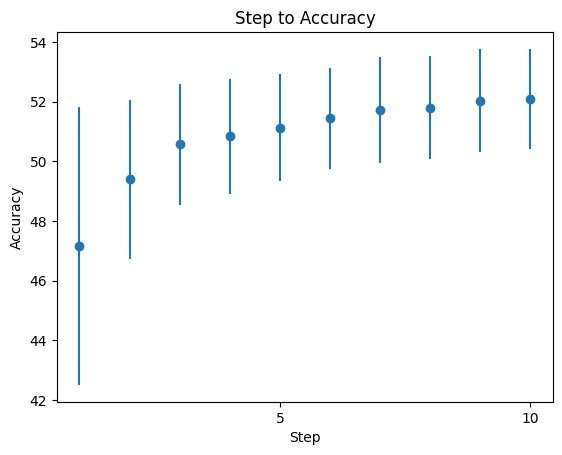

In [7]:
import statistics
import matplotlib.pyplot as plt

# load opro.json
with open(SAVE_PATH) as f:
    opro_results = json.load(f)

# opro = {step:dict(sorted(opro[step].items(), key=lambda x: x[1], reverse=True)[:20]) for step in opro}
step_to_accuracy = {
    step: (
        statistics.mean(opro_results[step].values()),
        statistics.stdev(opro_results[step].values()),
    )
    for step in opro_results
}

# Plot step to accuracy as a continuous line graph, including stdevs as highlighted error bars
fig, ax = plt.subplots()
ax.errorbar(
    step_to_accuracy.keys(),
    [accuracy[0] for accuracy in step_to_accuracy.values()],
    yerr=[accuracy[1] for accuracy in step_to_accuracy.values()],
    fmt="o",
)
ax.set_xticks([step for step in step_to_accuracy.keys() if int(step) % 5 == 0])
ax.set_xlabel("Step")
ax.set_ylabel("Accuracy")
ax.set_title("Step to Accuracy")

In [8]:
opro_results[str(len(opro_results))]

{'**Instruction**: Summarize the following text:\n\n**{TEXT}**\n\n**Example:**\n\n* Summarize the following text:\n> The United States is a large country with a diverse population. It is made up of 50 states, each with its own unique culture and history. The United States is a global superpower and has a significant influence on world affairs.\n\n### Answer: ###\n* The United States is a large, diverse country with 50 states, each with its own unique culture and history. As a global superpower, the United States exerts significant influence on world affairs.\n\n**Additional Instructions:**\n\n* Please ensure that your summary captures the key points of the text.\n* Use clear and concise language.\n* You MUST adhere to the specified word limit.\n* You will be penalized if your summary is not responsive to the text.': 57.20792197129059,
 '**Optimal Summary Creation Framework**\n\n#### Directive:\n\nCraft a brief yet thorough summary of the specified text.\n\n#### Text for Summary:\n{TEXT

In [9]:
best_instruction = max(
    opro_results[str(len(opro_results))], key=opro_results[str(len(opro_results))].get
)
print(f"Initial Prompt: {score(CHOSEN_PROMPT, testing_sample)}")
print(f"Optimized Prompt ({best_instruction}): {score(best_instruction, testing_sample)}")

Please summarize the following text: {TEXT}:   0%|          | 0/30 [00:00<?, ?it/s]

Initial Prompt: 37.307090432010874


**Instruction**: Summarize the following text:

**{TEXT}**

**Example:**

* Summarize the following text:
> Th…

Optimized Prompt (**Instruction**: Summarize the following text:

**{TEXT}**

**Example:**

* Summarize the following text:
> The United States is a large country with a diverse population. It is made up of 50 states, each with its own unique culture and history. The United States is a global superpower and has a significant influence on world affairs.

### Answer: ###
* The United States is a large, diverse country with 50 states, each with its own unique culture and history. As a global superpower, the United States exerts significant influence on world affairs.

**Additional Instructions:**

* Please ensure that your summary captures the key points of the text.
* Use clear and concise language.
* You MUST adhere to the specified word limit.
* You will be penalized if your summary is not responsive to the text.): 43.59918060057396
